In [1]:
# Configure JAX
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from onequtritpulsesimulator import OneQutritPulseSimulator

In [4]:
import numpy as np

from qiskit import pulse
from qiskit.circuit import Parameter, Gate
from qiskit_experiments.curve_analysis.fit_function import *

import matplotlib.pyplot as plt
from scipy.optimize import *

### Instantiation a backend and defining appropriate channels

In [5]:
sim = OneQutritPulseSimulator()
backend = sim.get_backend()

In [6]:
dchan = pulse.DriveChannel(0)
achan = pulse.AcquireChannel(0)
memslot = pulse.MemorySlot(0)

### Defining some helpful pulse preparation functions.

In [7]:
# Defining shifted pulse for 0-1 transition
def get_shifted_x01_pulse(frequency, amplitude, dchan, achan, momslot):
    with pulse.build(name="x01") as x01_pulse:
        pulse.set_frequency(frequency, dchan)
        pulse.play(pulse.Gaussian(320, amplitude, 80, limit_amplitude=False), dchan)
        pulse.delay(320, achan)
        pulse.acquire(1, achan, memslot)
    return x01_pulse


# Defining shifted pulse for 0-2 transition
def get_shifted_x02_pulse(frequency, ef_frequency, amplitude, ef_amplitude, beta, dchan, achan, memslot):
    with pulse.build(name="x") as x02_pulse:
        pulse.set_frequency(frequency, dchan)
        pulse.play(pulse.Drag(320, amplitude, 80, beta, limit_amplitude=False), dchan)
        pulse.set_frequency(ef_frequency, dchan)
        pulse.play(pulse.Gaussian(320, ef_amplitude, 80, limit_amplitude=False), dchan)
        pulse.delay(640, achan)
        pulse.acquire(1, achan, memslot)
    return x02_pulse

## Identifying optimal frequency for $|0\rangle \xrightarrow{} |1\rangle$ transition

In this experiment, we will obtain the frequency corresponding to the $|0\rangle \xrightarrow{} |1\rangle$ transition. This is obtained by sweeping over a range of frequency values and identifying the frequency where the largest absorption (or, largest dip in the population of $|0\rangle $ ) is seen.

In [8]:
min_frequency = 4.9e9
max_frequency = 5.1e9
steps = 100

sweep_frequency_list = np.linspace(min_frequency, max_frequency, steps)

results_array = []
memory_array = []

for frequency in sweep_frequency_list:
    freq_test_pulse = get_shifted_x01_pulse(frequency, 0.05, dchan, achan, memslot)
    
    freq_job = backend.run(freq_test_pulse)
    results_array.append(freq_job.result())

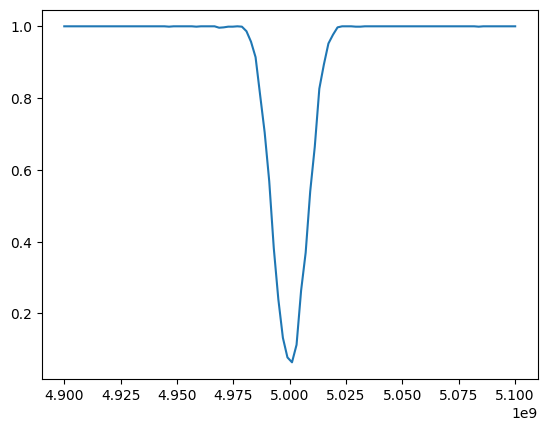

In [9]:
zero_population_array = []
for result in results_array:
    count = result.get_counts()['0']
    zero_population_array.append(count/1024.)

import matplotlib.pyplot as plt

plt.plot(sweep_frequency_list, zero_population_array)

We can clearly see that the largest absorption is seen at the frequency $5.0e9$. So, the transition frequency for the $|0\rangle \rightarrow |1\rangle $ is $\text{freq} = 5.0e9$.

In [10]:
opt_params_freq, _ = curve_fit(sqrt_lorentzian, sweep_frequency_list, zero_population_array, bounds=([-1, 10e5, sweep_frequency_list[0], 0.5], [0, 10e6, sweep_frequency_list[-1], 1.5]))

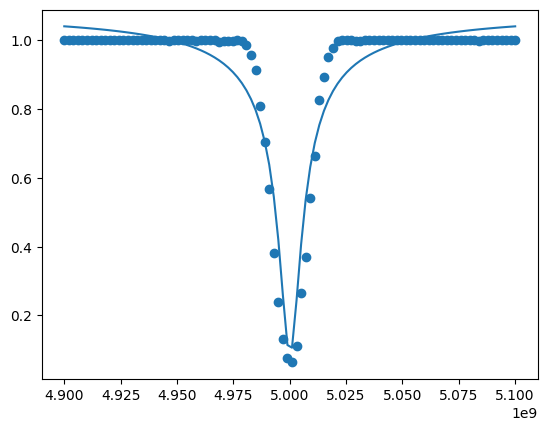

In [11]:
plt.scatter(sweep_frequency_list, zero_population_array)
plt.plot(sweep_frequency_list, sqrt_lorentzian(sweep_frequency_list, *opt_params_freq))

In [12]:
freq = opt_params_freq[2]
print(f"The frequency of the transiiton |0⟩ -> |1⟩ is {freq}.")

The frequency of the transiiton |0⟩ -> |1⟩ is 5000086871.548919.


## Identifying optimal amplitude for $|0\rangle \xrightarrow{} |1\rangle$ transition

In the next experiment, we obtain the optimal amplitude that excites the complete population of $|0\rangle$ to the state $|1\rangle$.

In [13]:
min_amplitude = 0
max_amplitude = 0.2
steps = 100

amplitude_results_array = []

sweep_amplitude_list = np.linspace(min_amplitude, max_amplitude, steps)

for amplitude in sweep_amplitude_list:
    amp_test_pulse = get_shifted_x01_pulse(freq, amplitude, dchan, achan, memslot)
    
    amp_job = backend.run(amp_test_pulse, meas_level=2, max_outcome_level=2)
    amplitude_results_array.append(amp_job.result())

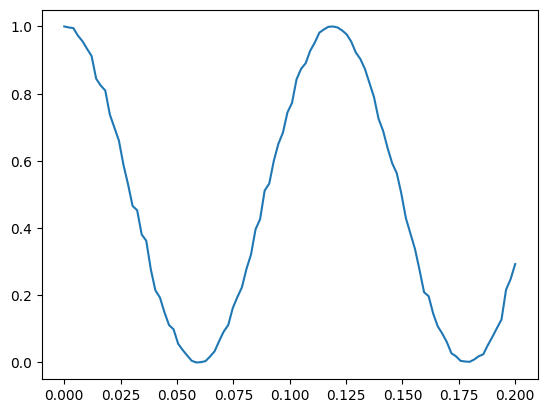

In [14]:
zero_population_array = []
for result in amplitude_results_array:
    if '0' in result.get_counts():
        count = result.get_counts()['0']
    else:
        count = 0
    zero_population_array.append(count/1024.)

plt.plot(sweep_amplitude_list, zero_population_array)

In [15]:
opt_params_amp, _ = curve_fit(cos, sweep_amplitude_list, zero_population_array, bounds=([0, 0, -2*np.pi, 0], [1, 20, np.pi, 1]))

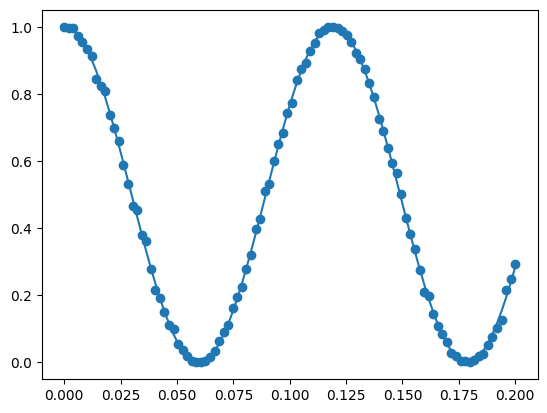

In [16]:
plt.scatter(sweep_amplitude_list, zero_population_array)
plt.plot(sweep_amplitude_list, cos(sweep_amplitude_list, *opt_params_amp))

In [17]:
amp = 1/(2*opt_params_amp[1])
print(f"The amplitude of the |0> -> |1> transition is {amp}.")

The amplitude of the |0> -> |1> transition is 0.059559844136557474.


## DRAG-Calibration for $|0\rangle \rightarrow |1\rangle$ transition.

We now have the transition frequency and the optimal transition amplitude. While the pulse primarily excites $|0\rangle$ to $|1\rangle$, the pulse also induces leakage to $|2\rangle$. To reduce that leakage, we use the DRAG technique. In this experiment, we will obtain the DRAG parameter $\beta$.

In [18]:
# Defining shifted drag pulse for 0-1 transition
def get_shifted_x01_drag_pulse(frequency, amplitude, beta, dchan, achan, memslot, num_reps):
    with pulse.build(name="x01") as x01_pulse:
        pulse.set_frequency(frequency, dchan)
        for i in range(num_reps):
            pulse.play(pulse.Drag(320, amplitude, 80, beta, limit_amplitude=False), dchan)
            pulse.shift_phase(np.pi, dchan)
            pulse.play(pulse.Drag(320, amplitude, 80, beta, limit_amplitude=False), dchan)
            pulse.shift_phase(np.pi, dchan)
        pulse.delay((640*num_reps), achan)
        pulse.acquire(1, achan, memslot)
    return x01_pulse

In [19]:
min_beta = -3
max_beta = 1
steps = 100

drag_results_array = [[], [], []]
n_reps_list = [3,5,7]

sweep_beta_list = np.linspace(min_beta, max_beta, steps)

for i, nreps in enumerate(n_reps_list):
    for beta in sweep_beta_list:
        drag_test_pulse = get_shifted_x01_drag_pulse(freq, amp, beta, dchan, achan, memslot, nreps)

        drag_job = backend.run(drag_test_pulse, meas_level=2, max_outcome_level=2)
        drag_results_array[i].append(drag_job.result())

In [20]:
one_population_list = [[], [], []]
for i in range(3):
    for result in drag_results_array[i]:
        if '1' in result.get_counts():
            count = result.get_counts()['1']
        else:
            count = 0
        one_population_list[i].append(count/1024.)

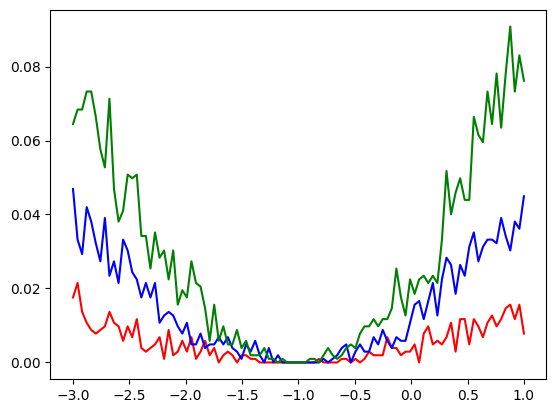

In [21]:
plt.plot(sweep_beta_list, one_population_list[0], color='r')
plt.plot(sweep_beta_list, one_population_list[1], color='b')
plt.plot(sweep_beta_list, one_population_list[2], color='g')

In [22]:
opt_params_drag_0, _ = curve_fit(cos, sweep_beta_list, one_population_list[0], bounds=([-10, 0, -2*np.pi, 0], [11, 0.1, np.pi, 0.11]))
opt_params_drag_1, _ = curve_fit(cos, sweep_beta_list, one_population_list[1], bounds=([-1, 0, -2*np.pi, -np.inf], [1, 0.1, np.pi, np.inf]))
opt_params_drag_2, _ = curve_fit(cos, sweep_beta_list, one_population_list[2], bounds=([-2, 0, -2*np.pi, -np.inf], [2, 0.5, np.pi, np.inf]))

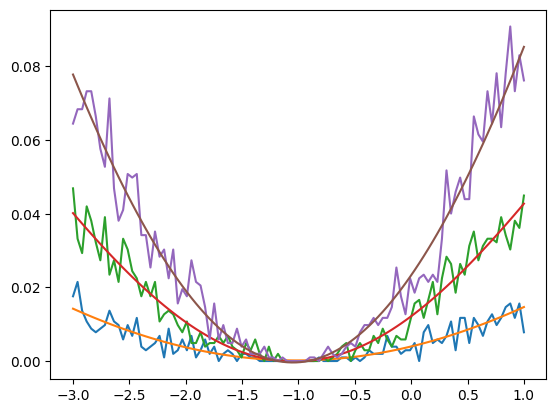

In [23]:
plt.plot(sweep_beta_list, one_population_list[0])
plt.plot(sweep_beta_list, cos(sweep_beta_list, *opt_params_drag_0))

plt.plot(sweep_beta_list, one_population_list[1])
plt.plot(sweep_beta_list, cos(sweep_beta_list, *opt_params_drag_1))

plt.plot(sweep_beta_list, one_population_list[2])
plt.plot(sweep_beta_list, cos(sweep_beta_list, *opt_params_drag_2))

In [24]:
opt_y_0 = cos(sweep_beta_list, *opt_params_drag_0)
opt_y_1 = cos(sweep_beta_list, *opt_params_drag_1)
opt_y_2 = cos(sweep_beta_list, *opt_params_drag_2)

opt_beta_list = [
    sweep_beta_list[np.where(opt_y_0 == min(opt_y_0))][0],
    sweep_beta_list[np.where(opt_y_1 == min(opt_y_1))][0],
    sweep_beta_list[np.where(opt_y_2 == min(opt_y_2))][0]
]

beta = max(set(list(opt_beta_list)), key=opt_beta_list.count)
print(f"The optimal beta value is {beta}.")

The optimal beta value is -1.02020202020202.


## Identifying optimal frequency for $|1\rangle \xrightarrow{} |2\rangle$ transition

Now, we characterize the $|1\rangle \rightarrow |2\rangle$ transitions. First, we obtain the optimal frequency that induces the $|1\rangle \rightarrow |2\rangle$ transition by sweeping over a range of frequency.

In [25]:
ef_min_frequency = 4.6e9
ef_max_frequency = 4.8e9
steps = 50

ef_freq_results_array = []

sweep_frequency_list = np.linspace(ef_min_frequency, ef_max_frequency, steps)

for frequency in sweep_frequency_list:
    ef_freq_test_pulse = get_shifted_x02_pulse(freq, frequency, amp, 0.15, beta, dchan, achan, memslot)
    
    ef_job = backend.run(ef_freq_test_pulse, meas_level=2, max_outcome_level=2)
    ef_freq_results_array.append(ef_job.result())

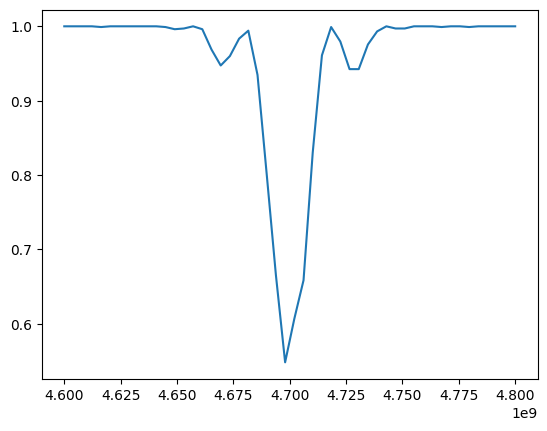

In [26]:
one_population_list = []

for result in ef_freq_results_array:
    if '1' in result.get_counts():
        count = result.get_counts()['1']
    else:
        count = 0
    one_population_list.append(count/1024.)

plt.plot(sweep_frequency_list, one_population_list)

In [27]:
opt_params_ef_freq, _ = curve_fit(sqrt_lorentzian, sweep_frequency_list, one_population_list, bounds=([-1, 10e5, sweep_frequency_list[0], 0.5], [0, 10e6, sweep_frequency_list[-1], 1.5]))

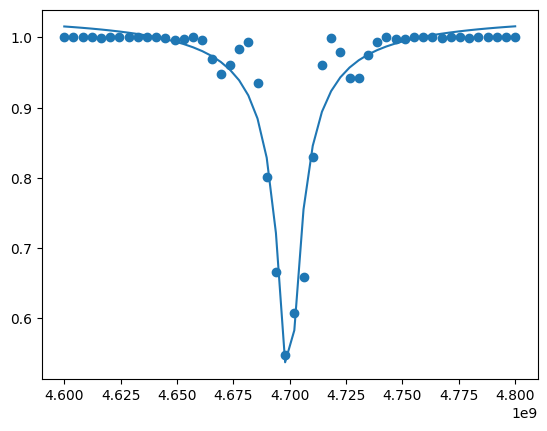

In [28]:
plt.scatter(sweep_frequency_list, one_population_list)
plt.plot(sweep_frequency_list, sqrt_lorentzian(sweep_frequency_list, *opt_params_ef_freq))

In [29]:
ef_freq = opt_params_ef_freq[2]
print(f"The frequency of the transiiton |0⟩ -> |1⟩ is {ef_freq}.")

The frequency of the transiiton |0⟩ -> |1⟩ is 4699498834.794182.


## Identifying optimal amplitude for $|1\rangle \xrightarrow{} |2\rangle$ transition

Given that we have obtained the transition frequency corresponding to the $|1\rangle \rightarrow |2\rangle $ transition, we continue on to obtain the optimal amplitude that excites all the population of $|1\rangle$ to $|2\rangle$.

In [30]:
ef_min_amplitude = 0
ef_max_amplitude = 0.2
steps = 100

sweep_amplitude_list = np.linspace(ef_min_amplitude, ef_max_amplitude, steps)

ef_amp_results_array = []

for amplitude in sweep_amplitude_list:
    ef_amp_test_pulse = get_shifted_x02_pulse(freq, ef_freq, amp, amplitude, beta, dchan, achan, memslot)
    
    ef_job = backend.run(ef_amp_test_pulse, meas_level=2, max_outcome_level=2)
    ef_amp_results_array.append(ef_job.result())

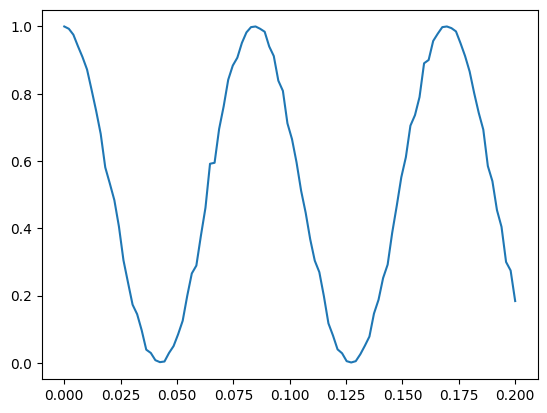

In [31]:
one_population_list = []

for result in ef_amp_results_array:
    if '1' in result.get_counts():
        count = result.get_counts()['1']
    else:
        count = 0
    one_population_list.append(count/1024.)

plt.plot(sweep_amplitude_list, one_population_list)

In [32]:
opt_params_ef_amp, _ = curve_fit(cos, sweep_amplitude_list, one_population_list, bounds=([0, 0, -2*np.pi, 0], [1, 20, np.pi, 1]))

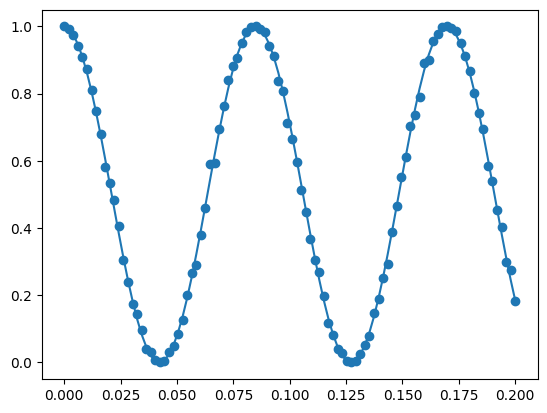

In [33]:
plt.scatter(sweep_amplitude_list, one_population_list)
plt.plot(sweep_amplitude_list, cos(sweep_amplitude_list, *opt_params_ef_amp))

In [34]:
ef_amp = 1/(2*opt_params_ef_amp[1])
print(f"The amplitude of the |1> -> |2> transition is {ef_amp}.")

The amplitude of the |1> -> |2> transition is 0.04244432269595312.


## DRAG-Calibration for 1->2 pulse

Finally, we  will obtain the DRAG parameter $\beta_{ef}$ to ensure leakage to any energy levels outside of the $|1\rangle-|2\rangle$ subspace is reduced.

In [35]:
# Defining shifted drag pulse for 0-1 transition
def get_shifted_x02_drag_pulse(frequency, ef_frequency, amplitude, ef_amplitude, bta, ef_beta, drive, achan, memslot, num_reps):
    with pulse.build(name="x02_drag") as x02_drag_pulse:
        pulse.set_frequency(frequency, drive)
        pulse.play(pulse.Drag(320, amplitude, 80, bta, limit_amplitude=False), drive)
        pulse.set_frequency(ef_frequency, drive)
        for i in range(num_reps):
            pulse.play(pulse.Drag(320, ef_amplitude, 80, ef_beta, limit_amplitude=False), drive)
            pulse.shift_phase(np.pi, drive)
            pulse.play(pulse.Drag(320, ef_amplitude, 80, ef_beta, limit_amplitude=False), drive)
            pulse.shift_phase(np.pi, drive)
        pulse.delay(640*(num_reps+1), achan)
        pulse.acquire(1, achan, memslot)
    return x02_drag_pulse

In [36]:
min_beta = -5
max_beta = -1
steps = 100

ef_drag_results_array = [[], [], []]
n_reps_list = [3,5,7]

sweep_beta_list = np.linspace(min_beta, max_beta, steps)

for i, nreps in enumerate(n_reps_list):
    for ef_beta in sweep_beta_list:
        drag_test_pulse = get_shifted_x02_drag_pulse(freq, ef_freq, amp, ef_amp, beta, ef_beta, dchan, achan, memslot, nreps)

        drag_job = backend.run(drag_test_pulse, meas_level=2, max_outcome_level=2)
        ef_drag_results_array[i].append(drag_job.result())

In [37]:
two_population_list = [[], [], []]
for i in range(3):
    for result in ef_drag_results_array[i]:
        if '2' in result.get_counts():
            count = result.get_counts()['2']
        else:
            count = 0
        two_population_list[i].append(count/1024.)

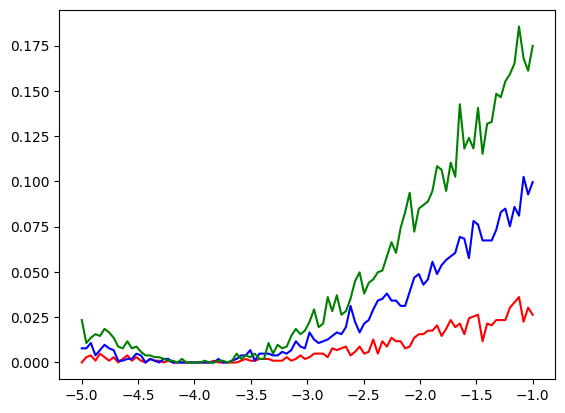

In [38]:
plt.plot(sweep_beta_list, two_population_list[0], color='r')
plt.plot(sweep_beta_list, two_population_list[1], color='b')
plt.plot(sweep_beta_list, two_population_list[2], color='g')

In [39]:
opt_params_ef_drag_0, _ = curve_fit(cos, sweep_beta_list, two_population_list[0], bounds=([-10, 0, -2*np.pi, 0], [11, 0.1, np.pi, 0.11]))
opt_params_ef_drag_1, _ = curve_fit(cos, sweep_beta_list, two_population_list[1], bounds=([-1, 0, -2*np.pi, -np.inf], [1, 0.1, np.pi, np.inf]))
opt_params_ef_drag_2, _ = curve_fit(cos, sweep_beta_list, two_population_list[2], bounds=([-2, 0, -2*np.pi, -np.inf], [2, 0.5, np.pi, np.inf]))

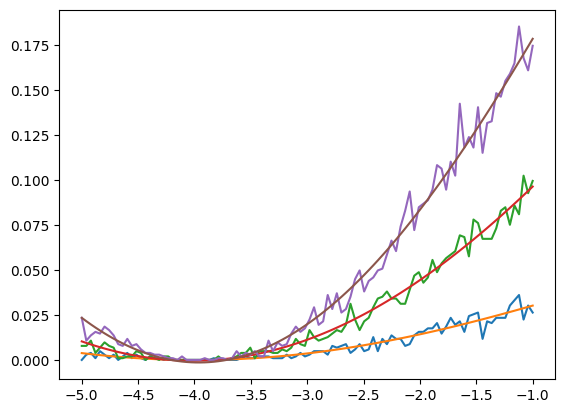

In [40]:
plt.plot(sweep_beta_list, two_population_list[0])
plt.plot(sweep_beta_list, cos(sweep_beta_list, *opt_params_ef_drag_0))

plt.plot(sweep_beta_list, two_population_list[1])
plt.plot(sweep_beta_list, cos(sweep_beta_list, *opt_params_ef_drag_1))

plt.plot(sweep_beta_list, two_population_list[2])
plt.plot(sweep_beta_list, cos(sweep_beta_list, *opt_params_ef_drag_2))

In [41]:
opt_y_0 = cos(sweep_beta_list, *opt_params_ef_drag_0)
opt_y_1 = cos(sweep_beta_list, *opt_params_ef_drag_1)
opt_y_2 = cos(sweep_beta_list, *opt_params_ef_drag_2)

opt_beta_list = [
    sweep_beta_list[np.where(opt_y_0 == min(opt_y_0))][0],
    sweep_beta_list[np.where(opt_y_1 == min(opt_y_1))][0],
    sweep_beta_list[np.where(opt_y_2 == min(opt_y_2))][0]
]

ef_beta = max(set(list(opt_beta_list)), key=opt_beta_list.count)
print(f"The optimal beta value is {ef_beta}.")

The optimal beta value is -3.9494949494949494.


--------------------------------------------------------------------------------------

## Testing the obtained frequency and amplitudes

In this experiment, we check if the obtained parameters are indeed optimal. For this, we perform two experiments. In the first experiment we construct a pulse to excite $|0\rangle$ to $|1\rangle$. In the second experiment, we try to construct the $|2\rangle$ state.

In [42]:
def get_x01_pulse(drive, achan, memslot):
    with pulse.build(name="x01") as x01:
        pulse.set_frequency(freq, drive)
        pulse.play(pulse.Drag(320, amp, 80, beta), drive)
        pulse.delay(320, achan)
        pulse.acquire(1, achan, memslot)
    return x01

def get_x02_pulse(drive, achan, memslot):
    with pulse.build(name="x02") as x02:
        pulse.set_frequency(freq, drive)
        pulse.play(pulse.Drag(320, amp, 80, beta), drive)
        pulse.set_frequency(ef_freq, drive)
        pulse.play(pulse.Drag(320, ef_amp, 80, ef_beta), drive)
        pulse.delay(640, achan)
        pulse.acquire(1, achan, memslot)
    return x02

#### Preparing the $|1\rangle$ state.

In [43]:
x01_pulse = get_x01_pulse(dchan, achan, memslot)

test_job_01 = backend.run(x01_pulse, meas_level=2, max_outcome_level=2)

counts = test_job_01.result().get_counts()
print(counts)

{np.str_('1'): np.int64(1024)}


Clearly, we obtain the state $|1\rangle$ with probability 1.

#### Preparing the $|2\rangle$ state.

In [44]:
x02_pulse = get_x02_pulse(dchan, achan, memslot)

test_job_02 = backend.run(x02_pulse, meas_level=2, max_outcome_level=2)

counts = test_job_02.result().get_counts()
print(counts)

{np.str_('2'): np.int64(1024)}


Again, we obtain the state $|2\rangle$ with probability almost 1.

---------------------------